# this notebook parse the **patch** data

In [1]:
import numpy as np
import argparse

from scipy.interpolate import interp1d

import json

import os
import math
from math import sin

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as pyo
import plotly.graph_objs as go

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *
from PatchParser import *
from TimeStampReader import *


from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='sub101')

# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/raw/', 
                          '--output_folder', '../../data/stage1/',
                          '--subject_id', 'sub107',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/raw/', output_folder='../../data/stage1/', subject_id='sub107')


In [3]:
inputdir = args.input_folder
outputdir = args.output_folder
subject_id = args.subject_id
# position = args.position

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
outputdir_sub = outputdir+subject_id+'/patch/'

if not os.path.exists(outputdir_sub):
    os.makedirs(outputdir_sub)

# read data from sternum, clavicle, and ribcage

In [4]:
raw_dict = {}

for sub_file in os.listdir(inputdir):

    if 'sub' not in sub_file:
        continue

    if sub_file.split('_')[0] != subject_id:
        continue
    for data_file in os.listdir(inputdir+sub_file):
        if '.mat' not in data_file:
            continue
        print(data_file)
        fileName = inputdir+sub_file+'/'+data_file
        
        if data_file!='HP_W50.1-1-20220105_143234.mat':
            continue
        raw_dict = scipy.io.loadmat(fileName)

# #         if position in data_file:
# #         if position in list_positions: 
#         for position in list_positions:
#             if position in data_file:
#                 print('\n', position)
#                 fileName = inputdir+sub_file+'/'+data_file
#                 print(fileName)

#                 file = open(fileName, mode='rb')
#                 fileContent = file.read()
#                 raw_dict[position] = parse(fileContent, header = True, print_updates = True, isConvUnits = True)
#                 raw_dict[position]['subject_id'] = subject_id

HP_W50.1-1-20220105_143234.mat
HP_W50.1-0-20220105_143234.mat


# which is raw dict???

In [5]:
raw_dict

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jan  5 15:46:18 2022',
 '__version__': '1.0',
 '__globals__': [],
 'file_imped': array([[(array([[ 485399729],
                [1923083987],
                [ 317297845],
                [2092953239]], dtype=int32), array([[87]], dtype=uint8), array([[50]], dtype=uint8), array([[1]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8), array([[61056]], dtype=uint16), MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                              [         2],
                              [         1],
                              [         1],
                              [         1],
                              [         1]], dtype=uint32))            ],
                      dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]), array([[2]], dtype=uint8), array([[4096]], dtype=uint16), array([[2664.7434082]]), array([[6576.84741211]]), array([[(array([[0]], dtype=uint8), 

In [6]:
fs_ast = raw_dict['file_imped'][0][0][9]
startTime = raw_dict['file_imped'][0][0][10]
stopTime = raw_dict['file_imped'][0][0][11]
audio_times= raw_dict['file_imped'][0][0][12]
tt_acc0 = raw_dict['file_imped'][0][0][13]
# acc0 = raw_dict['file_imped'][0][0][14]
# startTime = raw_dict['file_imped'][0][0][15]
# startTime = raw_dict['file_imped'][0][0][16]
acc0 = raw_dict['file_imped'][0][0][17]
tt_imped = raw_dict['file_imped'][0][0][23]
real = raw_dict['file_imped'][0][0][26]

acc0_new_data =  raw_dict['file_imped'][0][0][21]

(1000, 1010)

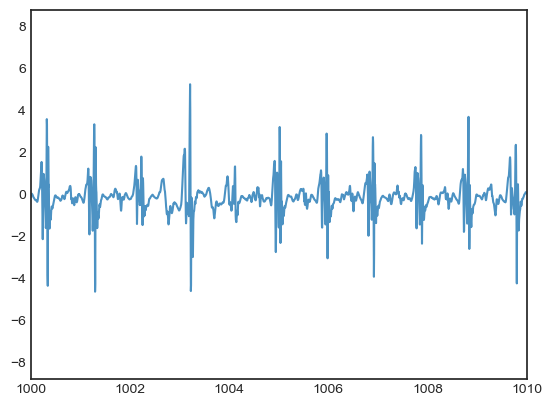

In [7]:
plt.plot(tt_acc0, acc0[:,2], alpha=0.8)
plt.xlim(1000,1010)
# plt.plot(tt_acc0, acc0_new_data[:,2], alpha=0.3)

(280, 282)

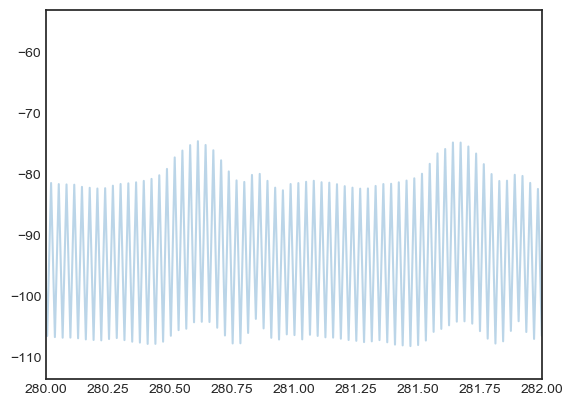

In [12]:
plt.plot(tt_imped[:-1000], real[:-1000], alpha=0.3)
# plt.plot(tt_acc0, acc0_new_data[:,2], alpha=0.3)
plt.xlim(280,282)

# list of sensors in the dataset
## `tri-axial gyro`
## `tri-axial accel`
## `5k Z`
## `100k Z`

In [9]:
# def data_interpolation(raw_dict, FS_RESAMPLE=500):

time_gyr0 = raw_dict['time_gyr0'].squeeze()
time_gyr1 = raw_dict['time_gyr1'].squeeze()
time_acc0 = raw_dict['time_acc0'].squeeze()
time_acc1 = raw_dict['time_acc1'].squeeze()
time_5k = raw_dict['time_5k'].squeeze()
time_100k = raw_dict['time_100k'].squeeze()


gyr0 = raw_dict['gyr0'].squeeze()
gyr1 = raw_dict['gyr1'].squeeze()
acc0 = raw_dict['acc0'].squeeze()
acc1 = raw_dict['acc1'].squeeze()
Resistance5 = raw_dict['Resistance5'].squeeze()
Resistance100 = raw_dict['Resistance100'].squeeze()

# t_start = np.max([time_gyr0[0], time_gyr1[0], time_acc0[0], time_acc1[0], time_5k[0], time_100k[0]])
t_start =  time_acc0[0]
t_end = np.min([time_gyr0[-1], time_gyr1[-1], time_acc0[-1], time_acc1[-1], time_5k[-1], time_100k[-1]])

time_interp = np.arange(my_ceil(t_start, decimal=-3)*FS_RESAMPLE, my_floor(t_end, decimal=-3)*FS_RESAMPLE+1)/FS_RESAMPLE

knee_dict = {}

# acc
f = interp1d(time_acc0, acc0, axis=0, fill_value="extrapolate")
acc0_interp = f(time_interp)
knee_dict['acc0_x'] = acc0_interp[:,0]
knee_dict['acc0_y'] = acc0_interp[:,1]
knee_dict['acc0_z'] = acc0_interp[:,2]

f = interp1d(time_acc1, acc1, axis=0, fill_value="extrapolate")
acc1_interp = f(time_interp)
knee_dict['acc1_x'] = acc1_interp[:,0]
knee_dict['acc1_y'] = acc1_interp[:,1]
knee_dict['acc1_z'] = acc1_interp[:,2]

# knee_dict['acc1'] = np.interp(time_interp, time_acc1, acc1)

# # gyr
f = interp1d(time_gyr0, gyr0, axis=0, fill_value="extrapolate")
gyr0_interp = f(time_interp)
knee_dict['gyr0_x'] = gyr0_interp[:,0]
knee_dict['gyr0_y'] = gyr0_interp[:,1]
knee_dict['gyr0_z'] = gyr0_interp[:,2]

f = interp1d(time_gyr1, gyr1, axis=0, fill_value="extrapolate")
gyr1_interp = f(time_interp)
knee_dict['gyr1_x'] = gyr1_interp[:,0]
knee_dict['gyr1_y'] = gyr1_interp[:,1]
knee_dict['gyr1_z'] = gyr1_interp[:,2]

# # gyr
f = interp1d(time_5k, Resistance5, axis=0, fill_value="extrapolate")
knee_dict['Resistance5'] = f(time_interp)

f = interp1d(time_100k, Resistance100, axis=0, fill_value="extrapolate")
knee_dict['Resistance100'] = f(time_interp)

knee_dict['time'] = time_interp - time_interp[0]
# knee_dict['gyr0'] = np.interp(time_interp, time_gyr0, gyr0)
# knee_dict['gyr1'] = np.interp(time_interp, time_gyr1, gyr1)

# # ACC
# patch_dict['accelX'] = np.interp(time_interp, raw_dict['accel_time'], raw_dict['accel_x'])
# patch_dict['accelY'] = np.interp(time_interp, raw_dict['accel_time'], raw_dict['accel_y'])
# patch_dict['accelZ'] = np.interp(time_interp, raw_dict['accel_time'], raw_dict['accel_z'])

# # TODO: find out which PPG arr this belongs to (in terms of its physical location)
# # PPG array 1 (which one is it? left or right?)
# patch_dict['ppg_g_1'] = np.interp(time_interp, raw_dict['ppg_time'], raw_dict['ppg_g_1'])
# patch_dict['ppg_r_1'] = np.interp(time_interp, raw_dict['ppg_time'], raw_dict['ppg_r_1'])
# patch_dict['ppg_ir_1'] = np.interp(time_interp, raw_dict['ppg_time'], raw_dict['ppg_ir_1'])

# # PPG array 2 (which one is it? left or right?)
# patch_dict['ppg_g_2'] = np.interp(time_interp, raw_dict['ppg_time'], raw_dict['ppg_g_2'])
# patch_dict['ppg_r_2'] = np.interp(time_interp, raw_dict['ppg_time'], raw_dict['ppg_r_2'])
# patch_dict['ppg_ir_2'] = np.interp(time_interp, raw_dict['ppg_time'], raw_dict['ppg_ir_2'])

# # skin temperature
# patch_dict['temp_skin'] = np.interp(time_interp, raw_dict['env_time'], medfilt(raw_dict['temp_skin'], k=3))
# # pressure
# patch_dict['pres'] = np.interp(time_interp, raw_dict['env_time'], get_smooth(raw_dict['pres'], N=51))

# time_interp = time_interp-time_interp[0]
# patch_dict['time'] = time_interp
# patch_dict['subject_id'] = raw_dict['subject_id']

# return patch_dict


KeyError: 'time_gyr0'

In [ ]:
df_knee = pd.DataFrame(knee_dict)

In [ ]:
# Create traces
fig = make_subplots(specs=[[{'secondary_y': True}]])
df = df_knee.copy()

t_start = 20
#     t_start = df_patch['time'].max()-20*60
t_end = 400
df = df[(df['time']>t_start) & (df['time']<t_end)] # ignore the last 60minutes because the study is at least 60 minute long prior to stop recording
downsample_factor = 1

alpha = 0.5

acc_x = df['acc0_x'].values
acc_y = df['acc0_y'].values
acc_z = df['acc0_z'].values

ts = df['time'].values


fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=acc_x[::downsample_factor],
                    mode='lines',
                    name='accelX',
                         opacity=alpha,
                      line=dict(color=color_dict[sync_color_dict['accelX']])),
              secondary_y=False,)

fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=acc_y[::downsample_factor],
                    mode='lines',
                    name='accelY',
                         opacity=alpha,
                      line=dict(color=color_dict[sync_color_dict['accelY']])),
              secondary_y=False,)

fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=acc_z[::downsample_factor],
                    mode='lines',
                    name='accelZ',
                         opacity=alpha,
                      line=dict(color=color_dict[sync_color_dict['accelZ']])),
              secondary_y=False,)


# Add figure title
fig.update_layout(
    title_text="inspect taps"
)

# Set y-axes titles
fig.update_yaxes(title_text="<b>signal (a.u.)</b>", secondary_y=False)

fig.update_xaxes(title_text="<b>time (sec)</b>")
fig.update_layout(plot_bgcolor='rgb(255,255,255)')

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)


# fig.show()
# sys.exit()
# else:
# tap_time = patch_tap_times[subject_id]
# print(tap_time)


In [ ]:
df_knee.to_feather(outputdir_sub+'df_knee.feather')

In [8]:
import mat73
# data_dict = mat73.loadmat('data.mat')

In [9]:
filedir = '../../data/raw/sub106/Subject106.mat'
raw_dict = mat73.loadmat(filedir)


In [12]:
raw_dict

{'Left': {'Reactance100': array([-1.68506072, -1.68841812, -1.71151892, ...,  1.45245678,
          1.40429394,  1.38035363]),
  'Reactance5': array([-11.7127452 , -11.73236039, -11.7127452 , ..., -13.21051478,
         -13.23234999, -13.24972628]),
  'Resistance100': array([92.77711191, 92.8497037 , 92.79454673, ..., 90.28855542,
         90.31902972, 90.37836361]),
  'Resistance5': array([133.41722762, 133.39542084, 133.41722762, ..., 136.50739735,
         136.49518898, 136.51129238]),
  'acc0': array([[ 0.02737,  1.27857, -0.26979],
         [ 0.02737,  1.27857, -0.26588],
         [ 0.01955,  1.27857, -0.26979],
         ...,
         [ 0.14076,  1.23165, -0.15249],
         [ 0.14076,  1.23556, -0.14858],
         [ 0.14467,  1.23165, -0.14858]]),
  'acc1': array([[-0.17595, -0.74681, -0.13294],
         [-0.17595, -0.74681, -0.12903],
         [-0.17595, -0.74681, -0.12903],
         ...,
         [ 0.68816, -0.30889,  0.24242],
         [ 0.68816, -0.30889,  0.24633],
         

In [ ]:
plt.plot(raw_dict['Right']['time_acc0'][:10000], raw_dict['Right']['acc0'][:10000])
# plt.plot()

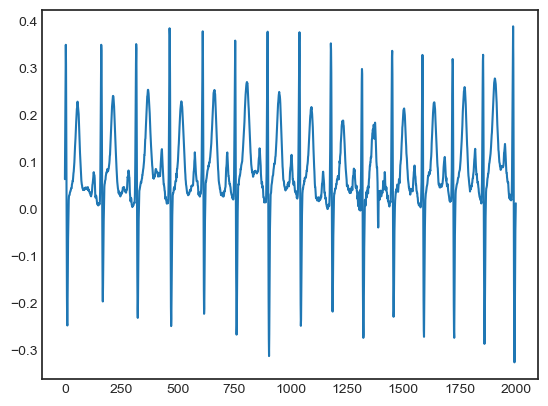

In [22]:
plt.plot(raw_dict['Patch'][5000:7000,20])